# Imports

In [1]:
import requests
import numpy as np
import pandas as pd
import json
from urllib.parse import urlencode
import typing
import http
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

## Open Data COVID-19 API

In [2]:
StructureType = typing.Dict[str,typing.Union[dict, str]]
FiltersType = typing.Iterable[str]
APIResponseType = typing.Union[typing.List[StructureType], str]

'''
    For this function, I refer to the API documentation provided by the Coursework 2 specifications.
    
    URL:
        https://coronavirus.data.gov.uk/details/developers-guide/main-api
'''


def get_API_data(filters,structure):
    """

        :param filters: A dictionary where keys are filter metrics and values are the values of those metrics. 
               structure: specify what information the query should return
            
        :return: a list of dictionaries answering the query.
        """
    
    
    
    ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

    result =[f"{key}={value}"for key,value in filters.items()] 
    filters = set(result)
    
    api_params = {
        "filters": str.join(";", filters),
        "structure": json.dumps(structure, separators=(",", ":")),
        "format":"json"
    }
    data = list()
    page_number = 1
    while True:
        # Adding page number to query params
        api_params["page"] = page_number
        
#         print(api_params)
        response = requests.get(ENDPOINT, params=api_params, timeout=10)

        if response.status_code >= http.HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == http.HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        page_data: typing.List[StructureType] = current_data['data']

        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1
    return data


In [3]:
structure = {
        "date": "date",
        "name": "areaName",
        "daily_cases": "newCasesBySpecimenDate",
        "cumulative_cases": "cumCasesBySpecimenDate",
        "daily_deaths": "newDeaths28DaysByPublishDate",
        "cumulative_deaths": "cumDeaths28DaysByPublishDate",
        "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
        "vaccination_age": "vaccinationsAgeDemographics"
}

filters_regional = {
    "areaType":"region"
}

filters_national = {
    "areaType":"nation"
}

results_json_national = get_API_data(filters_national,structure)
results_json_regional = get_API_data(filters_regional,structure)

In [4]:
print("There are {} records in results_json_regional list".format(len(results_json_regional)))
print("There are {} records in results_json_national list".format(len(results_json_national)))

There are 6313 records in results_json_regional list
There are 2796 records in results_json_national list


## Shaping the COVID data into different dataframes

In [5]:
concatenate_list = results_json_national + results_json_regional
print("There are {} records returned by quiring the API".format(len(concatenate_list)))

There are 9109 records returned by quiring the API


In [ ]:
# Transform the list into data frame
covid_data = pd.DataFrame(concatenate_list)
covid_data

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
0,2022-01-20,England,NaN,NaN,280.0,133245.0,NaN,[]
1,2022-01-19,England,46293.0,13255586.0,301.0,132965.0,40058085.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
2,2022-01-18,England,86128.0,13209293.0,400.0,132664.0,40034759.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
3,2022-01-17,England,100092.0,13123165.0,63.0,132264.0,40011668.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
4,2022-01-16,England,75667.0,13023073.0,79.0,132201.0,39990798.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,[]
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,[]
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,[]
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,[]


In [ ]:
# Erase all rows in which the name column have the value “England”.
England_index = covid_data[covid_data['name']=='England'].index.to_list()
covid_data = covid_data.drop(England_index)
covid_data

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,NaN,2.0,3056.0,NaN,[]
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,NaN,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,NaN,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,NaN,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,NaN,[]
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,[]
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,[]
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,[]
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,[]


In [8]:
# The column name has an ambiguous title. Change it to area.
covid_data.rename(columns={"name":"area"},inplace=True)
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,NaN,2.0,3056.0,NaN,[]
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,NaN,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,NaN,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,NaN,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,NaN,[]
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,[]
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,[]
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,[]
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,[]


In [9]:
# Convert date to the datetime type.
covid_data['date'] = pd.to_datetime(covid_data['date'])
covid_data.date

722    2022-01-20
723    2022-01-19
724    2022-01-18
725    2022-01-17
726    2022-01-16
          ...    
9104   2020-02-09
9105   2020-02-08
9106   2020-02-07
9107   2020-02-06
9108   2020-02-05
Name: date, Length: 8387, dtype: datetime64[ns]

**Handle the missing data**<br>
for daily_cases, cumulative_cases, daily_deaths, cumulative_deaths, cumulative_vaccinated, I count cells with NaN as missing data<br>
for vaccination_age I count cells with empty list as missing data 

**Number of missing value in each column**

In [10]:
vaccination_age = covid_data['vaccination_age']
boolean_empty_vaccination_age = vaccination_age.map(lambda x: x==[])
vaccination_age[boolean_empty_vaccination_age] = np.nan
print(covid_data.isnull().sum())

date                        0
area                        0
daily_cases                13
cumulative_cases           13
daily_deaths             1699
cumulative_deaths        1665
cumulative_vaccinated    4213
vaccination_age          4308
dtype: int64


<ipython-input-10-724f2d10128a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_age[boolean_empty_vaccination_age] = np.nan


**Summary of covid_data dataframe**

In [11]:
print(covid_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8387 entries, 722 to 9108
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8387 non-null   datetime64[ns]
 1   area                   8387 non-null   object        
 2   daily_cases            8374 non-null   float64       
 3   cumulative_cases       8374 non-null   float64       
 4   daily_deaths           6688 non-null   float64       
 5   cumulative_deaths      6722 non-null   float64       
 6   cumulative_vaccinated  4174 non-null   float64       
 7   vaccination_age        4079 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 589.7+ KB
None


In [12]:
print(len(covid_data))
print(len(covid_data.drop_duplicates(subset=["date","area"])))

8387
8386


In [ ]:
# Replace missing values with the most recent (up to the date corresponding to that missing value) existing values for that area.
area_list = covid_data['area'].unique().tolist()
# Covid_data_area_copy = {}
for current_area in area_list:
    covid_data.loc[covid_data["area"] == current_area, "cumulative_deaths"] = covid_data[covid_data["area"]==current_area]["cumulative_deaths"].fillna(method="bfill")
    covid_data.loc[covid_data["area"] == current_area, "cumulative_vaccinated"] = covid_data[covid_data["area"]==current_area]["cumulative_vaccinated"].fillna(method="bfill")
    covid_data.loc[covid_data["area"] == current_area, "cumulative_cases"] = covid_data[covid_data["area"]==current_area]["cumulative_cases"].fillna(method="bfill")

# drop duplicate
# from the previous cell, I notice that there is a duplicate data, which means data with same day and same
# area has been collected twice, if not deleted, when ploting data, there will be some weird peak pattern

covid_data = covid_data.drop_duplicates(subset=["date","area"])
print(covid_data.isnull().sum())
covid_data

date                        0
area                        0
daily_cases                12
cumulative_cases            0
daily_deaths             1699
cumulative_deaths        1651
cumulative_vaccinated    3550
vaccination_age          4307
dtype: int64


,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,496038.0,2.0,3056.0,33197.0,NaN
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,33197.0,NaN
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,33197.0,NaN
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,33197.0,NaN
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,33197.0,NaN
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,NaN
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,NaN
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,NaN
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,NaN


In [ ]:
# remove cumulative_cases with null values
cumulative_cases_null_index = covid_data[pd.isnull(covid_data['cumulative_cases'])].index.to_list()
covid_data = covid_data.drop(cumulative_cases_null_index)

# remove cumulative_deaths with null values
cumulative_deaths_null_index = covid_data[pd.isnull(covid_data['cumulative_deaths'])].index.to_list()
covid_data = covid_data.drop(cumulative_deaths_null_index)

# remove cumulative_vaccinated with null values
cumulative_vaccinated_null_index = covid_data[pd.isnull(covid_data['cumulative_vaccinated'])].index.to_list()
covid_data = covid_data.drop(cumulative_vaccinated_null_index)

print(covid_data.isnull().sum())
covid_data

date                       0
area                       0
daily_cases               12
cumulative_cases           0
daily_deaths               1
cumulative_deaths          0
cumulative_vaccinated      0
vaccination_age          777
dtype: int64


,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,496038.0,2.0,3056.0,33197.0,NaN
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,33197.0,NaN
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,33197.0,NaN
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,33197.0,NaN
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,33197.0,NaN
...,...,...,...,...,...,...,...,...
8797,2020-12-12,South East,3288.0,173887.0,77.0,6585.0,1293.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
8798,2020-12-11,South East,4075.0,170599.0,33.0,6508.0,1292.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
8799,2020-12-10,South East,3593.0,166524.0,54.0,6475.0,1286.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
8800,2020-12-09,South East,3230.0,162931.0,64.0,6421.0,1278.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


In [ ]:
area = covid_data['area'].unique().tolist()
result = {}

# create a dictionary{area_name: corresponding data frame}
for current in area:
    result[current] = covid_data[covid_data['area']== current].copy(deep=True)

daily_cases_roll_avg_dict = {}
daily_deaths_roll_avg_dict = {}
for area,data_frame in result.items():
    data_frame = data_frame.sort_values(by=['date'])
    # Compute rolling averages
    daily_cases_roll_avg_dict[area] = data_frame['daily_cases'].rolling(7,min_periods=1).mean()
    daily_deaths_roll_avg_dict[area] = data_frame['daily_deaths'].rolling(7,min_periods=1).mean()
    result[area] = data_frame
    result[area]['daily_cases_roll_avg'] = daily_cases_roll_avg_dict[area]
    result[area]['daily_deaths_roll_avg'] = daily_deaths_roll_avg_dict[area]

In [16]:
covid_data = pd.DataFrame(columns=['date','area','daily_cases','cumulative_cases','daily_deaths','cumulative_deaths','cumulative_vaccinated','vaccination_age','daily_cases_roll_avg','daily_deaths_roll_avg'])
for area,data_frame in result.items():
    covid_data = covid_data.append(data_frame)
covid_data.sort_index(ascending=True)

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age,daily_cases_roll_avg,daily_deaths_roll_avg
722,2022-01-20,Northern Ireland,NaN,496038.0,2.0,3056.0,33197.0,NaN,3958.500000,3.571429
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,33197.0,NaN,3827.857143,5.285714
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,33197.0,NaN,3700.285714,4.714286
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,33197.0,NaN,3507.857143,4.000000
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,33197.0,NaN,3326.857143,4.285714
...,...,...,...,...,...,...,...,...,...,...
8797,2020-12-12,South East,3288.0,173887.0,77.0,6585.0,1293.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",3464.000000,57.600000
8798,2020-12-11,South East,4075.0,170599.0,33.0,6508.0,1292.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",3508.000000,52.750000
8799,2020-12-10,South East,3593.0,166524.0,54.0,6475.0,1286.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",3319.000000,59.333333
8800,2020-12-09,South East,3230.0,162931.0,64.0,6421.0,1278.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",3182.000000,62.000000


In [ ]:
# Drop column daily_cases and daily_deaths
covid_data = covid_data.drop(['daily_cases','daily_deaths'],axis=1)
covid_data

,date,area,cumulative_cases,cumulative_deaths,cumulative_vaccinated,vaccination_age,daily_cases_roll_avg,daily_deaths_roll_avg
1104,2021-01-03,Northern Ireland,73738.0,1354.0,1271.0,NaN,1515.000000,6.000000
1103,2021-01-04,Northern Ireland,75608.0,1366.0,1271.0,NaN,1692.500000,9.000000
1102,2021-01-05,Northern Ireland,77119.0,1384.0,1271.0,NaN,1632.000000,12.000000
1101,2021-01-06,Northern Ireland,78551.0,1397.0,1271.0,NaN,1582.000000,12.250000
1100,2021-01-07,Northern Ireland,79702.0,1414.0,1271.0,NaN,1495.800000,13.200000
...,...,...,...,...,...,...,...,...
7777,2022-01-16,West Midlands,1361260.0,15772.0,4060988.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",9214.285714,23.285714
7776,2022-01-17,West Midlands,1373248.0,15777.0,4063276.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",9225.857143,23.000000
7775,2022-01-18,West Midlands,1383312.0,15818.0,4065890.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",9176.142857,22.571429
7774,2022-01-19,West Midlands,1388665.0,15860.0,4068086.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy...",8604.000000,23.571429


In [ ]:
#  Copy the columns date, area, and vaccination_age into a new dataframe named covid_data_vaccinations
covid_data_vaccinations = pd.DataFrame(covid_data,columns=['date','area','vaccination_age'])

# Drop vaccination_age from covid_data
covid_data = covid_data.drop(['vaccination_age'],axis=1)
covid_data_vaccinations

,date,area,vaccination_age
1104,2021-01-03,Northern Ireland,NaN
1103,2021-01-04,Northern Ireland,NaN
1102,2021-01-05,Northern Ireland,NaN
1101,2021-01-06,Northern Ireland,NaN
1100,2021-01-07,Northern Ireland,NaN
...,...,...,...
7777,2022-01-16,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
7776,2022-01-17,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
7775,2022-01-18,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
7774,2022-01-19,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


In [ ]:
# First, for the NaN in vaccination_age, delete them.
covid_data_vaccinations = covid_data_vaccinations.dropna()
covid_data_vaccinations

,date,area,vaccination_age
1797,2020-12-28,Scotland,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
1796,2020-12-29,Scotland,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
1795,2020-12-30,Scotland,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
1794,2020-12-31,Scotland,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
1793,2021-01-01,Scotland,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
...,...,...,...
7778,2022-01-15,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
7777,2022-01-16,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
7776,2022-01-17,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
7775,2022-01-18,West Midlands,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


In [ ]:
# Then explode it and transform it
covid_data_vaccinations = covid_data_vaccinations.explode("vaccination_age")
covid_data_vaccinations = pd.concat([covid_data_vaccinations,covid_data_vaccinations['vaccination_age'].apply(pd.Series)],axis=1).drop('vaccination_age',axis=1)
order = ['date','area','age','VaccineRegisterPopulationByVaccinationDate','cumPeopleVaccinatedCompleteByVaccinationDate','newPeopleVaccinatedCompleteByVaccinationDate','cumPeopleVaccinatedFirstDoseByVaccinationDate','newPeopleVaccinatedFirstDoseByVaccinationDate','cumPeopleVaccinatedSecondDoseByVaccinationDate','newPeopleVaccinatedSecondDoseByVaccinationDate','cumVaccinationFirstDoseUptakeByVaccinationDatePercentage','cumVaccinationCompleteCoverageByVaccinationDatePercentage','cumVaccinationSecondDoseUptakeByVaccinationDatePercentage']
covid_data_vaccinations_wide = pd.DataFrame(covid_data_vaccinations,columns=order)
covid_data_vaccinations_wide

,date,area,age,VaccineRegisterPopulationByVaccinationDate,cumPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
1797,2020-12-28,Scotland,12_15,234135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1797,2020-12-28,Scotland,16_17,110139.0,0.0,0.0,47.0,2.0,0.0,0.0,0.0,0.0,0.0
1797,2020-12-28,Scotland,18_29,833947.0,0.0,0.0,12189.0,182.0,0.0,0.0,1.5,0.0,0.0
1797,2020-12-28,Scotland,30_39,729735.0,0.0,0.0,16069.0,224.0,0.0,0.0,2.2,0.0,0.0
1797,2020-12-28,Scotland,40_49,674290.0,0.0,0.0,18990.0,235.0,0.0,0.0,2.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7774,2022-01-19,West Midlands,70_74,296458.0,281641.0,6.0,283831.0,7.0,281641.0,6.0,95.7,95.0,95.0
7774,2022-01-19,West Midlands,75_79,232861.0,223673.0,1.0,225122.0,5.0,223673.0,1.0,96.7,96.1,96.1
7774,2022-01-19,West Midlands,80_84,155191.0,149045.0,0.0,149955.0,2.0,149045.0,0.0,96.6,96.0,96.0
7774,2022-01-19,West Midlands,85_89,93002.0,88965.0,3.0,89607.0,0.0,88965.0,3.0,96.3,95.7,95.7


## Aggregating, plotting, and analysing

In [ ]:
# Show the cumulative cases in London
london_cumulative_cases = covid_data[covid_data['area'] =='London'][['date','area','cumulative_cases']]
london_cumulative_cases

,date,area,cumulative_cases
6014,2020-12-08,London,190451.0
6013,2020-12-09,London,194854.0
6012,2020-12-10,London,199851.0
6011,2020-12-11,London,205322.0
6010,2020-12-12,London,209982.0
...,...,...,...
5610,2022-01-16,London,2111844.0
5609,2022-01-17,London,2125086.0
5608,2022-01-18,London,2136556.0
5607,2022-01-19,London,2141877.0


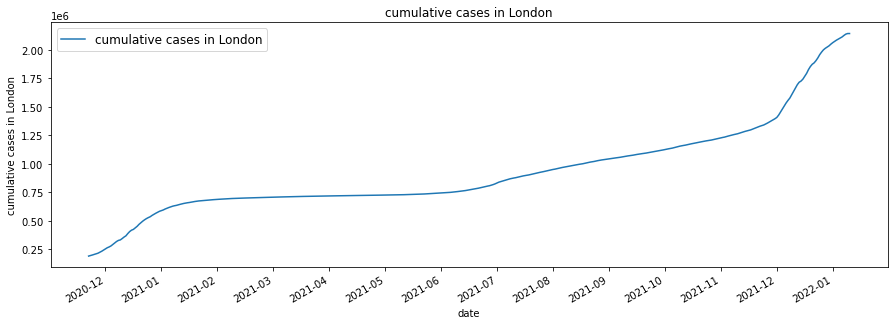

In [ ]:
# Plot to visualised the transformed data
fig = plt.figure(figsize=(15, 5))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set the interval on x axis every 30 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

# Avoid any potential overlap of the label
plt.gcf().autofmt_xdate()


plt.plot(london_cumulative_cases['date'],london_cumulative_cases['cumulative_cases'])
plt.title('cumulative cases in London')
plt.legend(labels=['cumulative cases in London'],loc="upper left",fontsize=12)

plt.xlabel('date')
plt.ylabel('cumulative cases in London')
plt.show()

<br>  From the figure, we can clearly see that during **Feburary,2021 to July,2021** the cases plateaued.

In [ ]:
# Show the cumulative cases summed over all areas
cumulative_cases_summed = covid_data.groupby('date')['cumulative_cases'].sum()
date = cumulative_cases_summed.index
cumulative_cases_summed

date
2020-12-08     1519479.0
2020-12-09     1536816.0
2020-12-10     1555207.0
2020-12-11     1574956.0
2020-12-12     1590898.0
                 ...    
2022-01-16    15255371.0
2022-01-17    15367829.0
2022-01-18    15463989.0
2022-01-19    15514762.0
2022-01-20    15514762.0
Name: cumulative_cases, Length: 409, dtype: float64

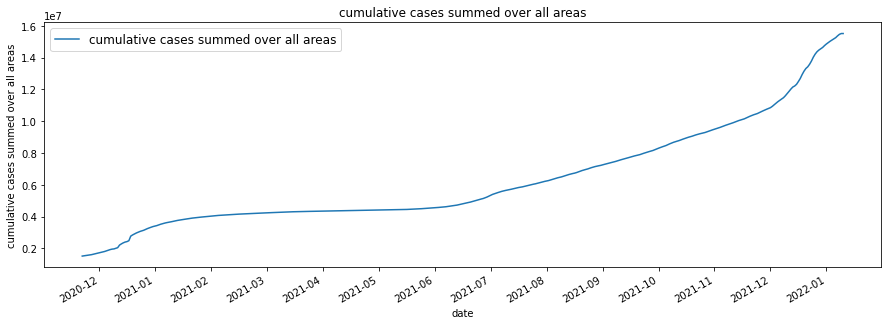

In [ ]:
# Plot to visualised the transformed data
fig = plt.figure(figsize=(15, 5))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set the interval on x axis every 30 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

# Avoid any potential overlap of the label
plt.gcf().autofmt_xdate()

plt.plot(date,cumulative_cases_summed)
plt.legend(labels=['cumulative cases summed over all areas'],loc="upper left",fontsize=12)

plt.title('cumulative cases summed over all areas')
plt.xlabel('date')
plt.ylabel('cumulative cases summed over all areas')
plt.show()

<br> From the figure, we can conclude that the pattern of cumulative cases summed over all areas is quite similar to that in London. Both graphs have a period in time in which the cases plateaued. For cumulative cases summed over all areas, the period  started from February 2021 and ended in June 2021

In [ ]:
# Prepare the data
region = covid_data['area'].unique().tolist()
cumulative_cases_from_different_areas = {}
for area in region:
    cumulative_cases_from_different_areas[area] = covid_data[covid_data['area'] ==area][['date','area','cumulative_cases']]


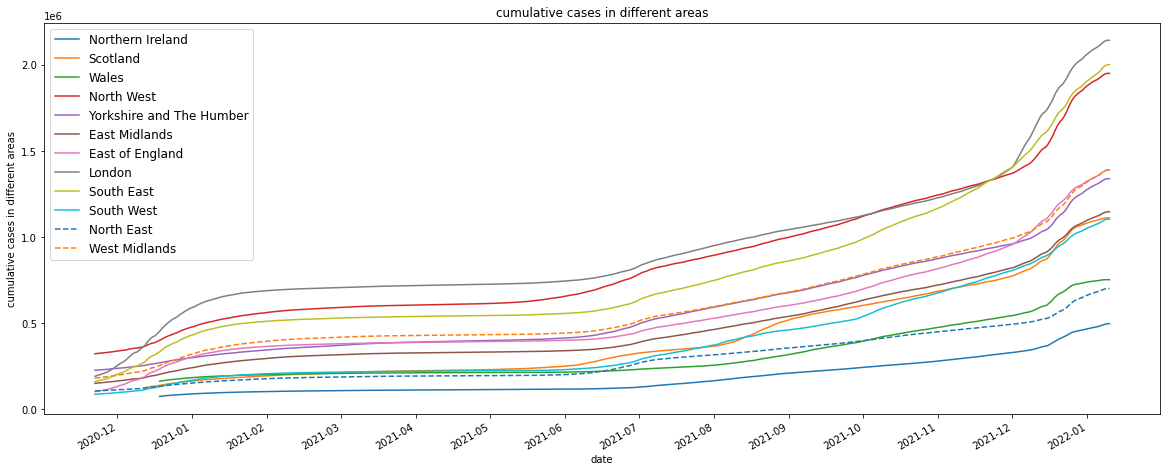

In [ ]:
# Plot to visualised the transformed data
fig = plt.figure(figsize=(20, 8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set the interval on x axis every 30 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

# Avoid any potential overlap of the label
plt.gcf().autofmt_xdate()

labels = []
k = 0

for key,value in cumulative_cases_from_different_areas.items():
    k +=1
    if k <= 10:
        plt.plot(value['date'],value['cumulative_cases'])
    else:
        plt.plot(value['date'],value['cumulative_cases'],ls='--')
    labels.append(key)

plt.title('cumulative cases in different areas')
plt.xlabel('date')
plt.ylabel('cumulative cases in different areas')
plt.legend(labels=labels,loc="upper left",fontsize=12)
plt.show()

<br> Cumulative cases in all nations/regions seem to share similar patterns, at first they increased rapidly before January 2021, then they all had a period in time in which the cases plateaued, which usually from February 2021 to June 2021, then cumulative cases increased even quicker, especially after November 2021.

<br> In June-July, the UK government gradually relaxed the lockdown regulation and began to reopen the economy, the cumulative cases began to increase at a higher rate. Apart from that, the spread of the Delta variant of the virus in the UK made covid-19 even more contagious. Both of them contributed to the trend of the acceleration of the cumulative cases during that period.

In [ ]:
# Show the cumulative death in London
london_cumulative_deaths = covid_data[covid_data['area'] =='London'][['date','area','cumulative_deaths']]
london_cumulative_deaths

,date,area,cumulative_deaths
6014,2020-12-08,London,7287.0
6013,2020-12-09,London,7322.0
6012,2020-12-10,London,7362.0
6011,2020-12-11,London,7396.0
6010,2020-12-12,London,7424.0
...,...,...,...
5610,2022-01-16,London,18031.0
5609,2022-01-17,London,18041.0
5608,2022-01-18,London,18092.0
5607,2022-01-19,London,18144.0


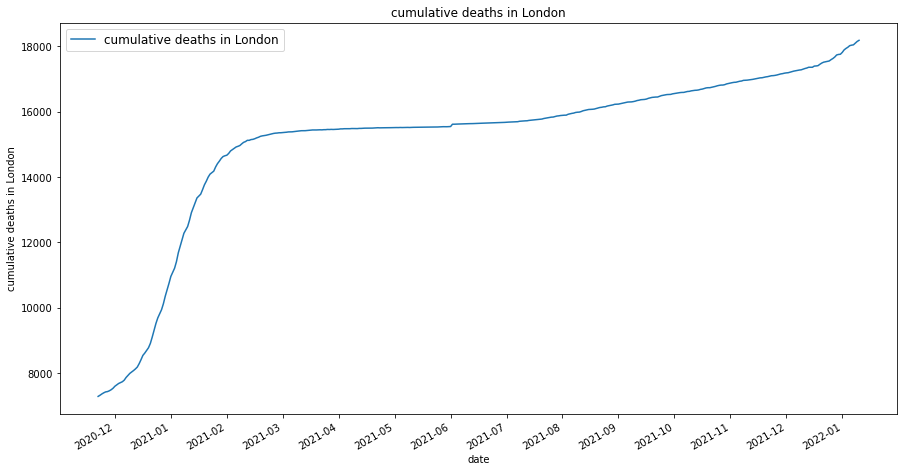

In [ ]:
# Plot to visualised the transformed data

fig = plt.figure(figsize=(15, 8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.plot(london_cumulative_deaths['date'],london_cumulative_deaths['cumulative_deaths'])
plt.title('cumulative deaths in London')

plt.xlabel('date')
plt.ylabel('cumulative deaths in London')
plt.legend(labels=['cumulative deaths in London'],loc="upper left",fontsize=12)
plt.show()

<br>From the graph above, we can see three trends and two periods in time when the ongoing trend is broken. The first one is between February 2021 and March 2021, before that time the cumulative deaths in London were increasing very fast, after that period the cumulative deaths increased slower compared to the previous period. And the second one is somewhere between August 2021 and September 2021 where the rate of the increase of cumulative deaths in London became larger after that period. 

<br>The trends between the cumulative cases and cumulative deaths are changing somehow 'synchronized'. Both cumulative deaths and cumulative cases rose rapidly before February and were relatively flat from February to June. The cumulative cases increased significantly from July to the end of December. The cumulative deaths also increased in July, but the growth rate was not as large as cumulative cases.

In [29]:
covid_data['cumulative_deaths_per_cases'] = covid_data['cumulative_deaths']/covid_data['cumulative_cases']
cumulative_deaths_per_cases_data = covid_data.groupby('date')['cumulative_deaths_per_cases'].sum()
cumulative_deaths_per_cases_date = cumulative_deaths_per_cases_data.index
cumulative_deaths_per_cases_data

date
2020-12-08    0.326467
2020-12-09    0.324965
2020-12-10    0.323123
2020-12-11    0.320681
2020-12-12    0.319718
                ...   
2022-01-16    0.116279
2022-01-17    0.115488
2022-01-18    0.115074
2022-01-19    0.114961
2022-01-20    0.115203
Name: cumulative_deaths_per_cases, Length: 409, dtype: float64

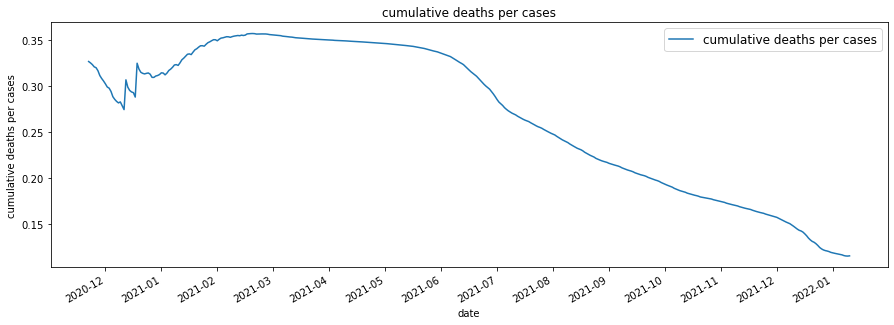

In [30]:
# 2 plot to visualised the transformed data
fig = plt.figure(figsize=(15, 5))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.plot(cumulative_deaths_per_cases_date,cumulative_deaths_per_cases_data)
plt.title('cumulative deaths per cases')
plt.xlabel('date')
plt.ylabel('cumulative deaths per cases')
plt.legend(labels=['cumulative deaths per cases'],loc="upper right",fontsize=12)
plt.show()

<br>Overall trend, there were fluctuations before January 2021, but the overall trend is downward

<br>June-July, the graph’s inclination gets steeper
<br>1.The virulence of the mutant strain weakened
<br>2.The medical staff are more experienced in dealing with the virus and taking care of patients
<br>3.The protective effect of the vaccine gradually appears with the increase of the vaccination rate

In [ ]:
# Sum of cumulative vaccinations over all areas as a function of time.
cumulative_vaccination_data = covid_data.groupby('date')['cumulative_vaccinated'].sum()
cumulative_vaccination_date = cumulative_vaccination_data.index
cumulative_vaccination_data

date
2020-12-08        7128.0
2020-12-09        7251.0
2020-12-10        7358.0
2020-12-11        7430.0
2020-12-12        7451.0
                 ...    
2022-01-16    44002107.0
2022-01-17    44025431.0
2022-01-18    44050530.0
2022-01-19    44075729.0
2022-01-20    44075729.0
Name: cumulative_vaccinated, Length: 409, dtype: float64

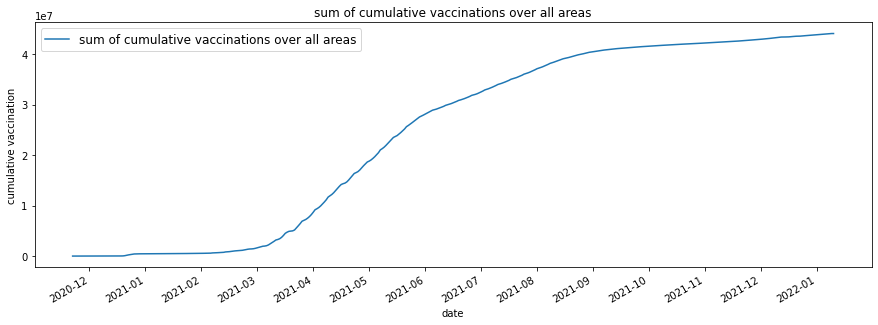

In [ ]:
# Plot to visualised the transformed data
fig = plt.figure(figsize=(15, 5))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()


plt.plot(cumulative_vaccination_date,cumulative_vaccination_data)
plt.title('sum of cumulative vaccinations over all areas')
plt.xlabel('date')
plt.ylabel('cumulative vaccination')
plt.legend(labels=['sum of cumulative vaccinations over all areas'],loc="upper left",fontsize=12)
plt.show()

<br>As we can see from the figure, the sum of cumulative vaccinations over all areas is rising. The protective effect of the vaccine gradually appears with the increase of the vaccination rate, which is a contributing factor for the decrease of cumulative deaths per case.

In [ ]:
# Prepare the data needed for plot.
area_list = covid_data['area'].unique().tolist()
daily_cases_rolling_average_from_different_areas = {}
for area in area_list:
    daily_cases_rolling_average_from_different_areas[area] = covid_data[covid_data['area'] ==area][['date','area','daily_cases_roll_avg']]

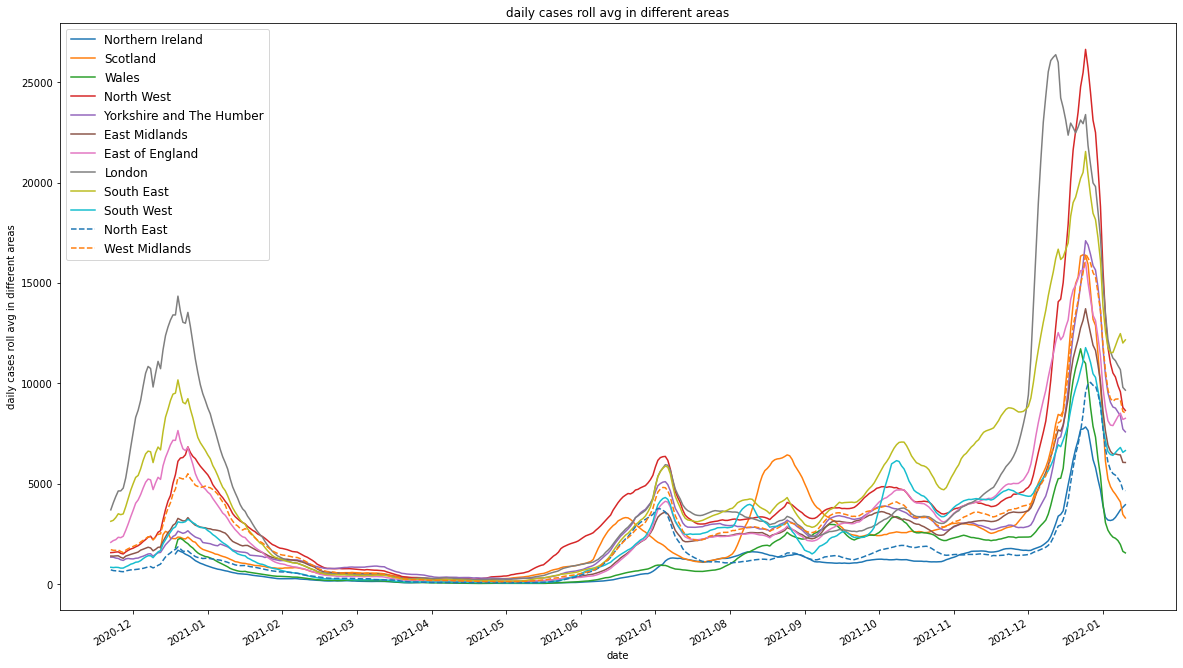

In [ ]:
# Plot to visualised the transformed data
fig = plt.figure(figsize=(20, 12))
# ax = fig.add_subplot(111)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
labels = []
k=0
for key,value in daily_cases_rolling_average_from_different_areas.items():
    k = k+1
    if k <= 10:
        plt.plot(value['date'],value['daily_cases_roll_avg'])
    else:
        plt.plot(value['date'],value['daily_cases_roll_avg'],ls='--')
    labels.append(key)
plt.title('daily cases roll avg in different areas')
plt.xlabel('date')
plt.ylabel('daily cases roll avg in different areas')
plt.legend(labels=labels,loc="upper left",fontsize=12)
plt.show()

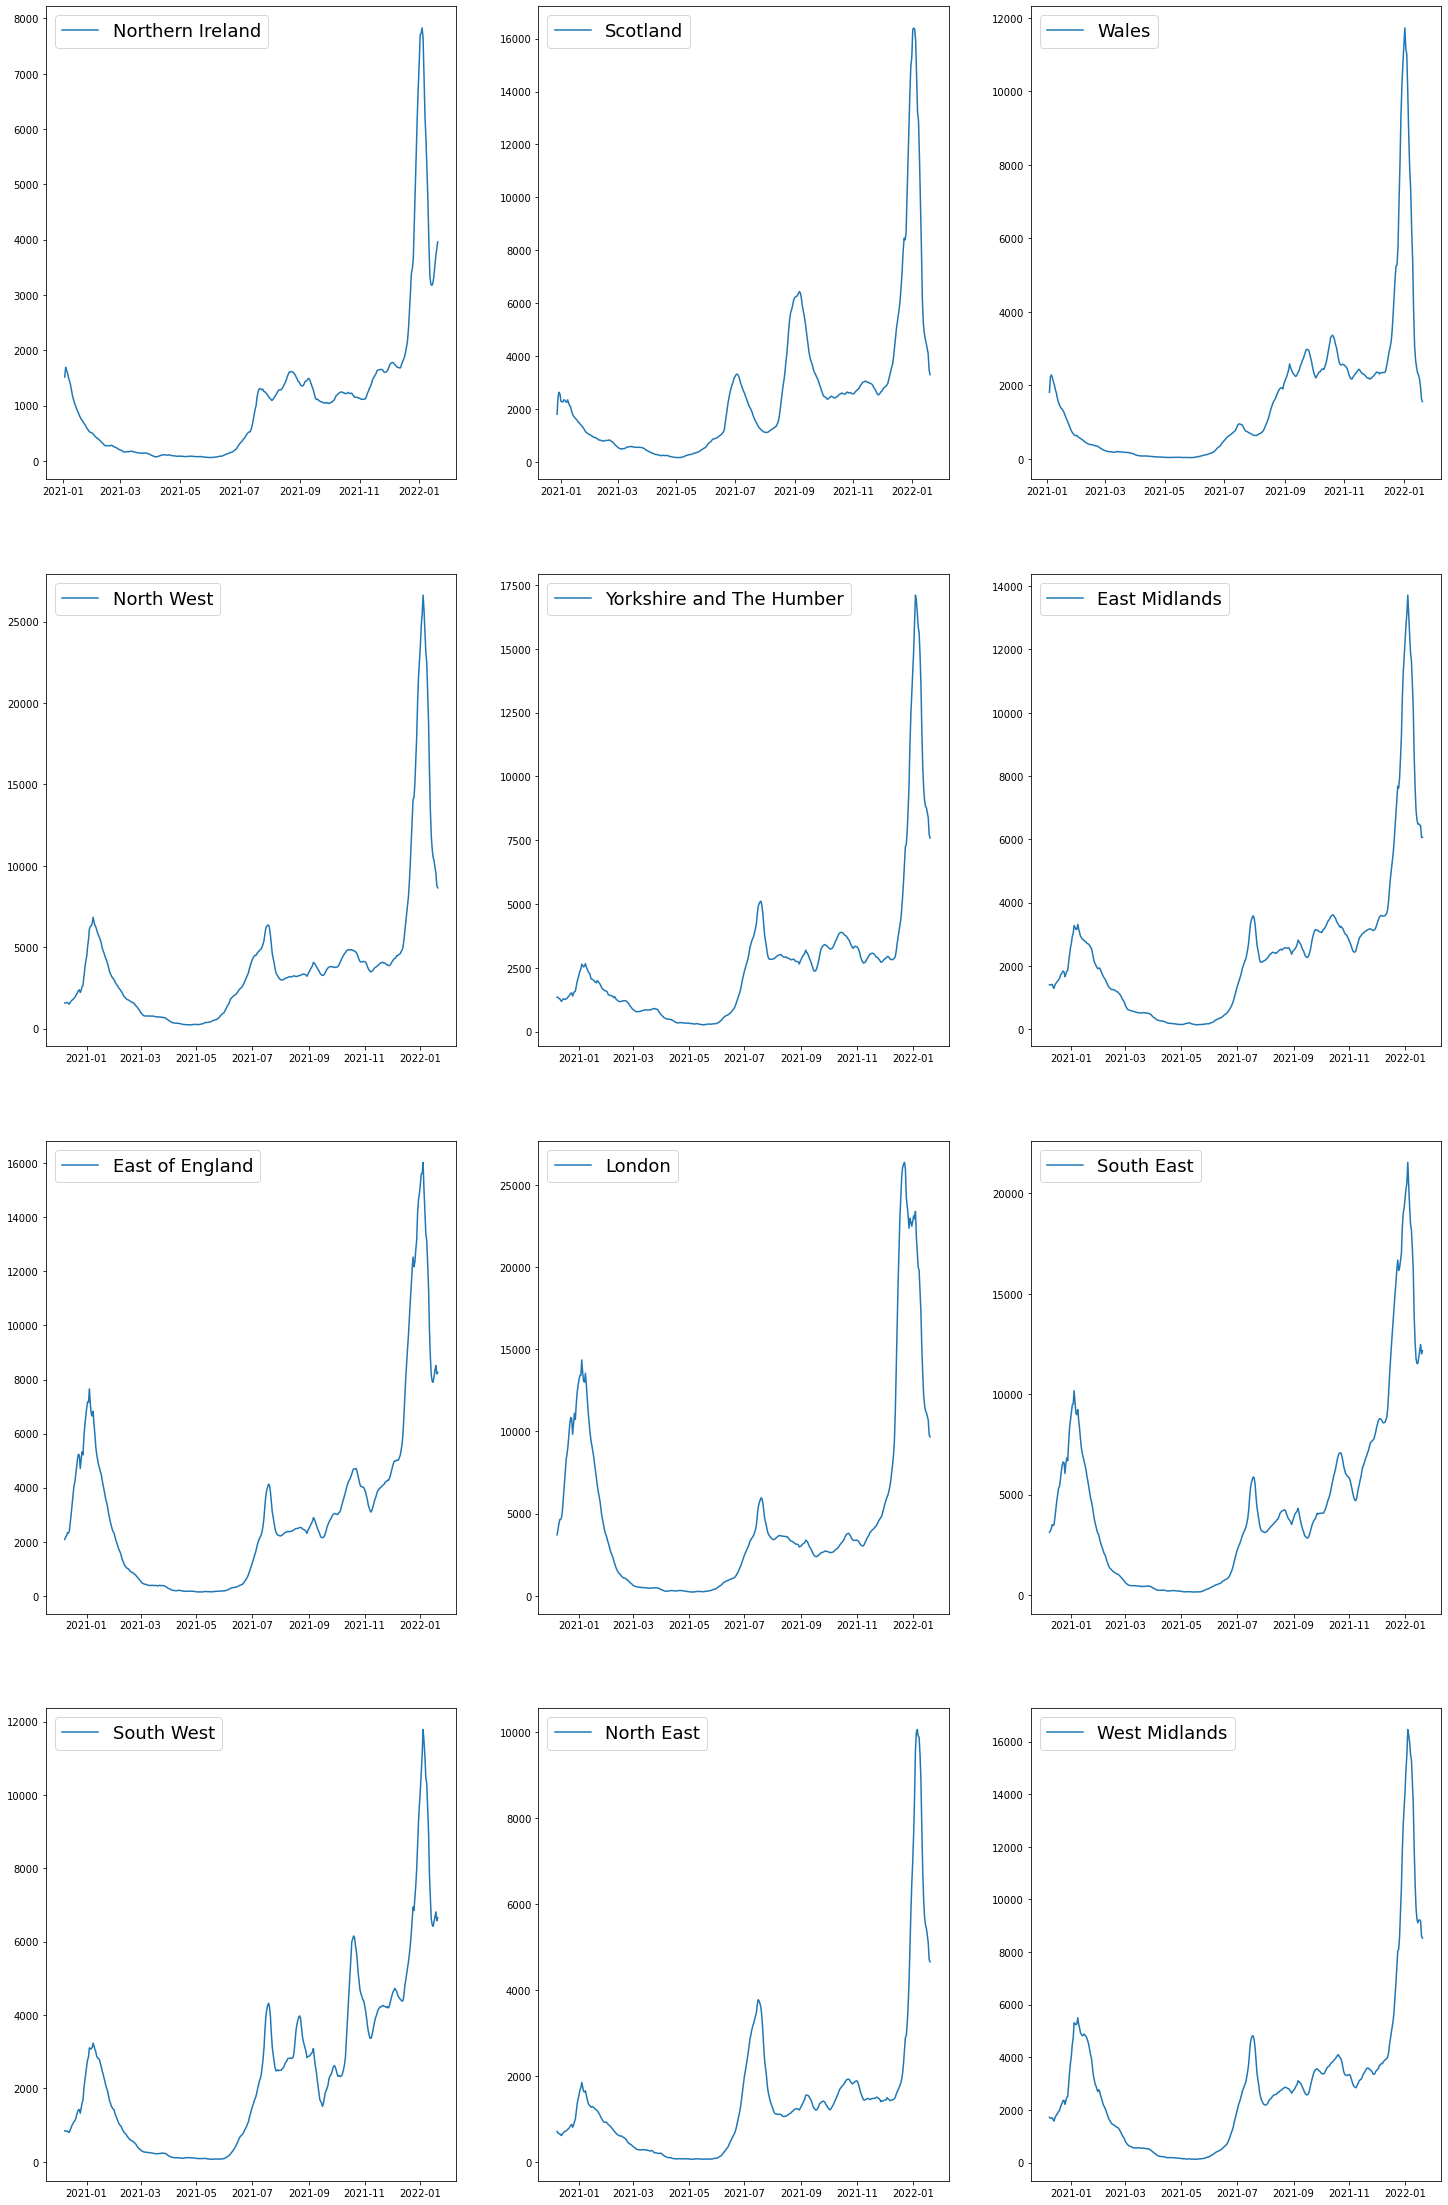

In [ ]:
# Drawing all curves on one plot is messy, so I create some subplots for each area.
fig = plt.figure(figsize=(25, 40))

for current_subplot in range(1,13):
    ax = fig.add_subplot(4,3,current_subplot)
    ax.plot(daily_cases_rolling_average_from_different_areas[area_list[current_subplot-1]]['date'],daily_cases_rolling_average_from_different_areas[area_list[current_subplot-1]]['daily_cases_roll_avg'])
    ax.legend(labels=[area_list[current_subplot-1]],loc="upper left",fontsize=18)

<br>From the graph above, Scotland seems to escape the general trend. It seems that Scotland escaped the first wave of the outbreak observed from the general trend, and the peak of the outbreaks in Scotland seems to be delayed compared with the general trend to some extent.

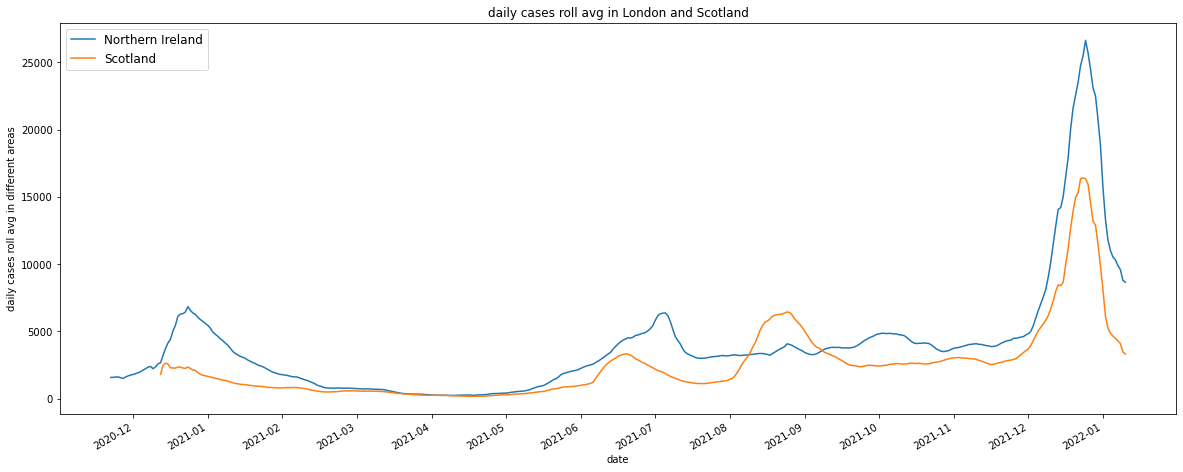

In [36]:
fig = plt.figure(figsize=(20, 8))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.plot(daily_cases_rolling_average_from_different_areas['London']['date'],daily_cases_rolling_average_from_different_areas['North West']['daily_cases_roll_avg'])
plt.plot(daily_cases_rolling_average_from_different_areas['Scotland']['date'],daily_cases_rolling_average_from_different_areas['Scotland']['daily_cases_roll_avg'])


labels.append('London')
labels.append('Scotland')

plt.title('daily cases roll avg in London and Scotland')
plt.xlabel('date')
plt.ylabel('daily cases roll avg in different areas')
plt.legend(labels=labels,loc="upper left",fontsize=12)
plt.show()

<br>Scotland's legal system is relatively independent, and the Scottish government have different judgments on the development of the pandemic. So, Scotland have taken different anti-epidemic measures. In addition, Scotland has a smaller population and a relatively low population density, so, the epidemic was  less severe at the beginning than other areas. But later, on July 2021, the European Cup began, people gathered to watch the game, a lot of people got infected, and the epidemic broke out in Scotland.

In [ ]:
# Prepare the data needed for plot.
covid_data['daily_cases_roll_avg_norm'] = covid_data['daily_cases_roll_avg']/np.max(covid_data['daily_cases_roll_avg'])
covid_data['daily_deaths_roll_avg_norm'] = covid_data['daily_deaths_roll_avg']/np.max(covid_data['daily_deaths_roll_avg'])
sum_daily_cases_roll_avg_norm = covid_data.groupby('date')['daily_cases_roll_avg_norm'].sum()
sum_daily_deaths_roll_avg_norm = covid_data.groupby('date')['daily_deaths_roll_avg_norm'].sum()
daily_cases_time = sum_daily_cases_roll_avg_norm.index
daily_deaths_time = sum_daily_deaths_roll_avg_norm.index

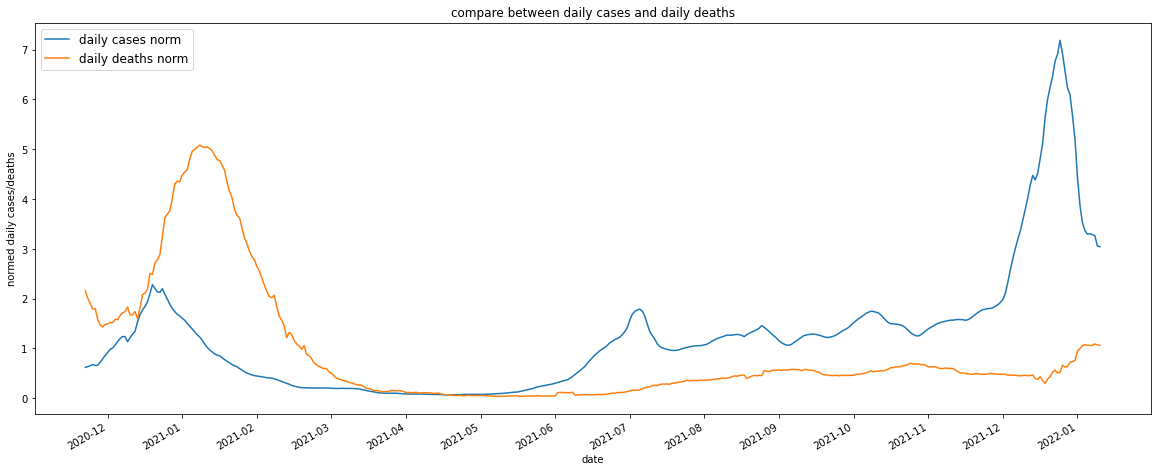

In [ ]:
# Plot to visualised the transformed data
fig = plt.figure(figsize=(20, 8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()


labels = []
plt.plot(daily_cases_time,sum_daily_cases_roll_avg_norm)
plt.plot(daily_deaths_time,sum_daily_deaths_roll_avg_norm)

labels.append('daily cases norm')
labels.append('daily deaths norm')

plt.title('compare between daily cases and daily deaths')
plt.xlabel('date')
plt.ylabel('normed daily cases/deaths')
plt.legend(labels=labels,loc="upper left",fontsize=12)
plt.show()

<br>The rate of the increase and decrease daily trend of the cases and deaths is represented by the slope of the curve in the image.In the early days, the rate of the increase and decrease daily trend of the cases and deaths was somewhat consistent. Later, the rate of the trend of daily deaths was lower than that of cases

In [ ]:
# Prepare data for London and Scotland
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area']=='London'].copy(deep=True)
covid_data_vaccinations_wide_Scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area']=='Scotland'].copy(deep=True)
# Display the Scotland data
covid_data_vaccinations_wide_Scotland

,date,area,age,VaccineRegisterPopulationByVaccinationDate,cumPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
1797,2020-12-28,Scotland,12_15,234135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1797,2020-12-28,Scotland,16_17,110139.0,0.0,0.0,47.0,2.0,0.0,0.0,0.0,0.0,0.0
1797,2020-12-28,Scotland,18_29,833947.0,0.0,0.0,12189.0,182.0,0.0,0.0,1.5,0.0,0.0
1797,2020-12-28,Scotland,30_39,729735.0,0.0,0.0,16069.0,224.0,0.0,0.0,2.2,0.0,0.0
1797,2020-12-28,Scotland,40_49,674290.0,0.0,0.0,18990.0,235.0,0.0,0.0,2.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,2022-01-19,Scotland,60_64,352569.0,355845.0,13.0,360761.0,5.0,355845.0,13.0,100.0,100.0,100.0
1410,2022-01-19,Scotland,65_69,300433.0,301857.0,8.0,305284.0,7.0,301857.0,8.0,100.0,100.0,100.0
1410,2022-01-19,Scotland,70_74,285830.0,284911.0,4.0,288022.0,4.0,284911.0,4.0,100.0,99.7,99.7
1410,2022-01-19,Scotland,75_79,198210.0,204426.0,7.0,207184.0,0.0,204426.0,7.0,100.0,100.0,100.0


In [ ]:
# Mould the London dataframe
covid_data_vaccinations_wide_london_mould = pd.pivot_table(covid_data_vaccinations_wide_london,index='date',values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage',columns='age').reset_index()
covid_data_vaccinations_wide_london_mould

age,date,12_15,16_17,18_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80_84,85_89,90+
0,2020-12-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1
1,2020-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.1
2,2020-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.0,0.0,0.3,0.4,0.3
3,2020-12-11,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.5,0.5,0.4
4,2020-12-12,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.7,0.7,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2022-01-15,40.2,51.7,61.1,63.8,61.9,63.5,68.1,73.5,78.0,80.8,83.5,85.6,88.5,89.7,89.7,89.9,88.5
404,2022-01-16,40.3,51.8,61.1,63.8,62.0,63.5,68.1,73.5,78.0,80.8,83.5,85.6,88.5,89.7,89.7,89.9,88.5
405,2022-01-17,40.4,51.8,61.2,63.8,62.0,63.5,68.1,73.5,78.0,80.8,83.5,85.7,88.5,89.7,89.7,89.9,88.5
406,2022-01-18,40.4,51.9,61.3,63.9,62.0,63.5,68.1,73.5,78.1,80.8,83.5,85.7,88.5,89.7,89.7,89.9,88.5


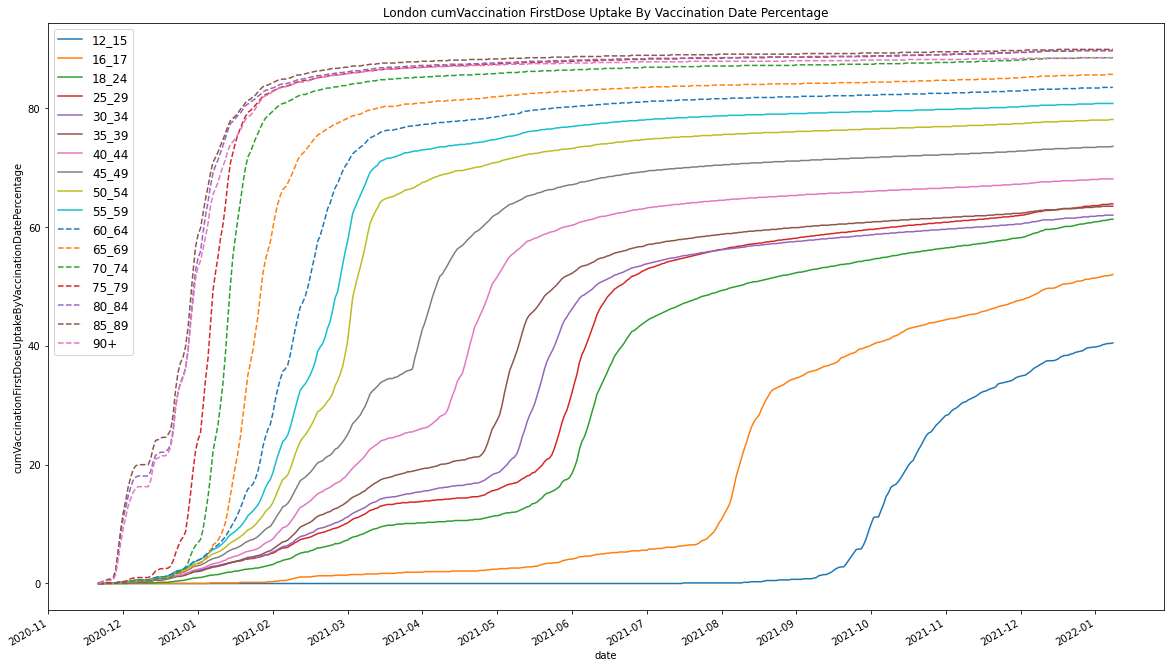

In [ ]:
age_interval = covid_data_vaccinations_wide_london_mould.columns[1:]
# Plot to visualised the transformed data
fig = plt.figure(figsize=(20, 12))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

labels = []
k=0
for key in age_interval:
    k = k+1
    if k <= 10:
        plt.plot(covid_data_vaccinations_wide_london_mould['date'],covid_data_vaccinations_wide_london_mould[key])
    else:
        plt.plot(covid_data_vaccinations_wide_london_mould['date'],covid_data_vaccinations_wide_london_mould[key],ls='--')
    labels.append(key)
plt.title('London cumVaccination FirstDose Uptake By Vaccination Date Percentage')
plt.xlabel('date')
plt.ylabel('cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')
plt.legend(labels=labels,loc="upper left",fontsize=12)
plt.show()

<br>From the figure, we can see that the elderly group is given priority to be vaccinated. In the elderly group, the vaccination rate exceeded 80 percent in February 2021. Among the 18-24 year olds, the vaccination rate will only reach about 50% in July 2021. Therefore, the vaccination strategy is to give priority to the vaccination of the elderly population. The reason is that the epidemic harms the elderly more than the young with strong immunity. Therefore, when vaccinating, it is necessary to give priority to the elderly who meet the vaccination conditions to protect them and reduce the harm caused by the virus to them.

In [ ]:
# Mould the Scotland dataframe
covid_data_vaccinations_wide_Scotland_mould = pd.pivot_table(covid_data_vaccinations_wide_Scotland,index='date',values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage',columns='age').reset_index()
covid_data_vaccinations_wide_Scotland_mould

age,date,12_15,16_17,18_29,30_39,40_49,50_54,55_59,60_64,65_69,70_74,75_79,80+
0,2020-12-28,0.0,0.0,1.5,2.2,2.8,3.2,3.3,2.5,1.1,0.5,0.8,3.5
1,2020-12-29,0.0,0.0,1.6,2.4,3.0,3.5,3.5,2.7,1.2,0.6,0.9,3.9
2,2020-12-30,0.0,0.0,1.7,2.5,3.2,3.7,3.8,2.9,1.3,0.6,1.0,4.3
3,2020-12-31,0.0,0.1,1.7,2.6,3.3,3.8,3.9,3.0,1.3,0.7,1.1,4.6
4,2021-01-01,0.0,0.1,1.7,2.6,3.3,3.8,3.9,3.0,1.3,0.7,1.1,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2022-01-15,66.9,81.7,80.4,85.8,92.6,97.0,99.5,100.0,100.0,100.0,100.0,100.0
384,2022-01-16,67.1,81.8,80.4,85.8,92.6,97.0,99.5,100.0,100.0,100.0,100.0,100.0
385,2022-01-17,67.2,81.8,80.5,85.8,92.6,97.0,99.5,100.0,100.0,100.0,100.0,100.0
386,2022-01-18,67.3,81.9,80.5,85.9,92.6,97.0,99.5,100.0,100.0,100.0,100.0,100.0


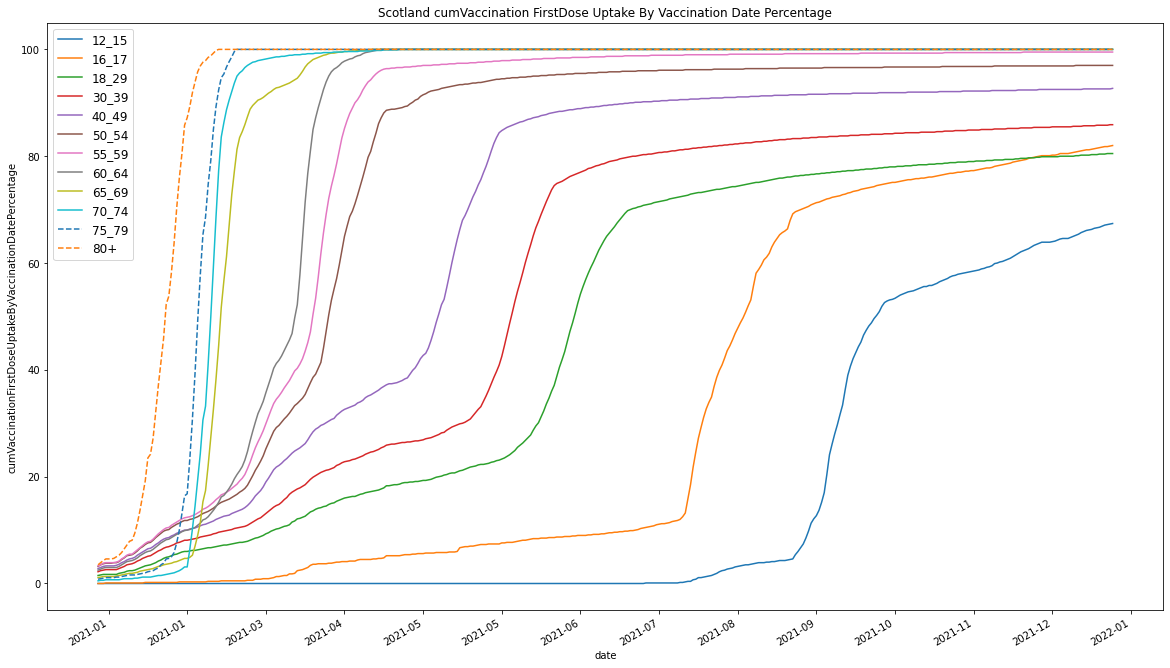

In [ ]:
age_interval = covid_data_vaccinations_wide_Scotland_mould.columns[1:]
# Plot to visualised the transformed data
fig = plt.figure(figsize=(20, 12))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

labels = []
k=0
for key in age_interval:
    k = k+1
    if k <= 10:
        plt.plot(covid_data_vaccinations_wide_Scotland_mould['date'],covid_data_vaccinations_wide_Scotland_mould[key])
    else:
        plt.plot(covid_data_vaccinations_wide_Scotland_mould['date'],covid_data_vaccinations_wide_Scotland_mould[key],ls='--')
    labels.append(key)
plt.title('Scotland cumVaccination FirstDose Uptake By Vaccination Date Percentage')
plt.xlabel('date')
plt.ylabel('cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')
plt.legend(labels=labels,loc="upper left",fontsize=12)
plt.show()

<br>From the figure, we can see that both Scotland and London give priority to providing vaccination for the elderly aged 65-79, and then for the population aged 50-64. The older, the earlier the vaccination. The vaccination strategies adopted by the two regions are very similar. However, there are some differences in the final vaccination rate between the two. It can be seen from the figure that in London, as of January 2022, the vaccination rate of people aged 50-64 is about 80%, and that of people aged 65-79 is about 90%. In Scotland, the vaccination rates of both groups are close to 100%.